In [ ]:
require(ggplot)
require(tidyverse)
require(ggcorrplot)
require(ggthemes)
require(cluster)
require(corrplot)
require(factoextra)
require(cowplot)

In [2]:
palette = c(
    "#2E9FDF", "#4782b3", "#E7B800",
    "#66acff", "#fff566", "#b34766",
    "#7a327d", "#66acff", "#ff6692",
    "#b3ab47", "#ffb3d7", "#66faff",
    "#7d7632", "#00AFBB", "#002db3",
    "#ff0000"
)

### Drop categorical and index column from PCA

In [3]:
data = read.csv("college.csv", header=TRUE, sep=",")

In [4]:
data = data %>% drop_na()
subdata = data[-c(1, 2, 3, 7)]
subdata = subdata

### Create correlation plot to check if PCA is worth applying

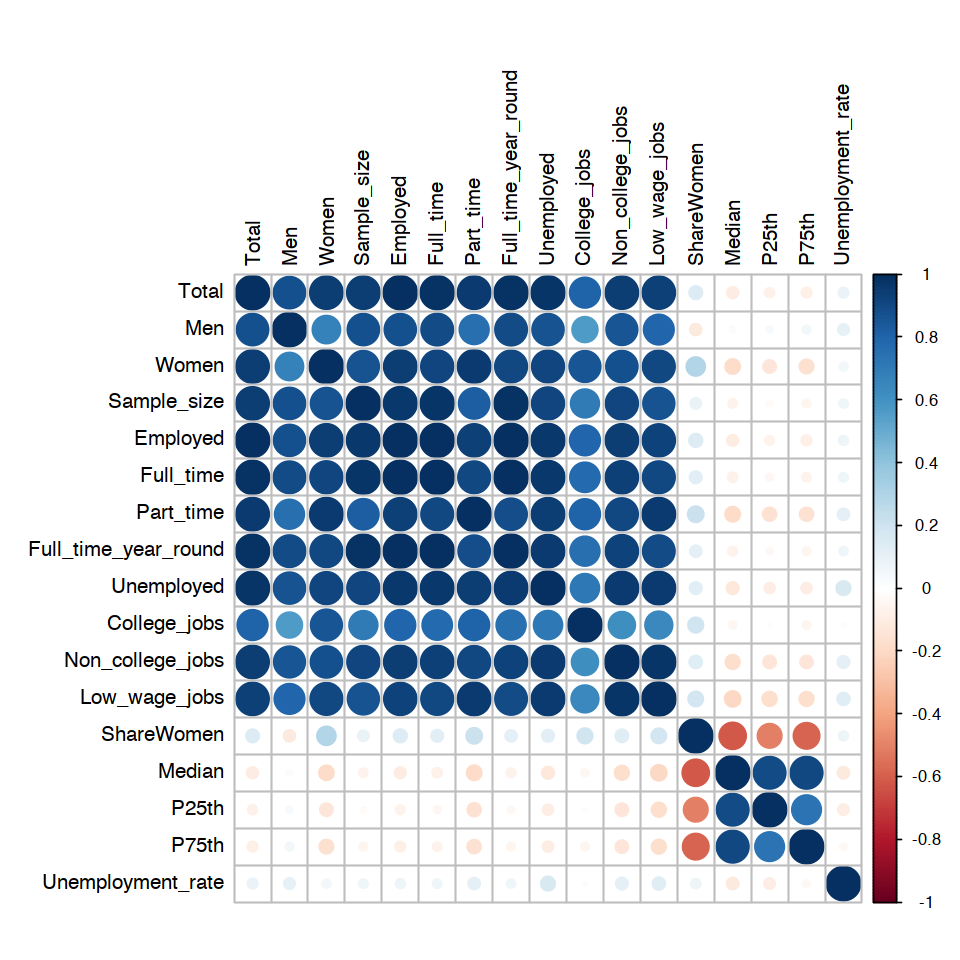

In [5]:
options(repr.plot.width=8, repr.plot.height=8)
# set income related variables to the end, in order to improve on 
# the visual aspect
subdata = subdata %>% relocate("ShareWomen", .after = last_col()) %>%
    relocate("Median", .after = last_col()) %>%
    relocate("P25th", .after = last_col()) %>%
    relocate("P75th", .after = last_col()) %>%
    relocate("Unemployment_rate", .after = last_col())
corrplot(cor(subdata), method="circle", tl.col = "black")

Groups of highly correlated variables that will be suitable for dimensionality reduction. Some of the existing features are computed from others. In this case the high correlation makes sense, but others, such as Share of women and median income have a negative correlation mostly as a result of socio-economic factors rather than feature engineering.

In [6]:
# Apply pca to the data and specify that the features should
# be scaled and centered
pca = prcomp(subdata, scale=TRUE, center=TRUE)

### Variance explained by the first 3 principal components

In [7]:
lambdas = pca$sdev^2
print(paste("Variance explained by first 2 components", round(sum(lambdas[1:2])/sum(lambdas), 2)))

[1] "Variance explained by first 2 components 0.83"


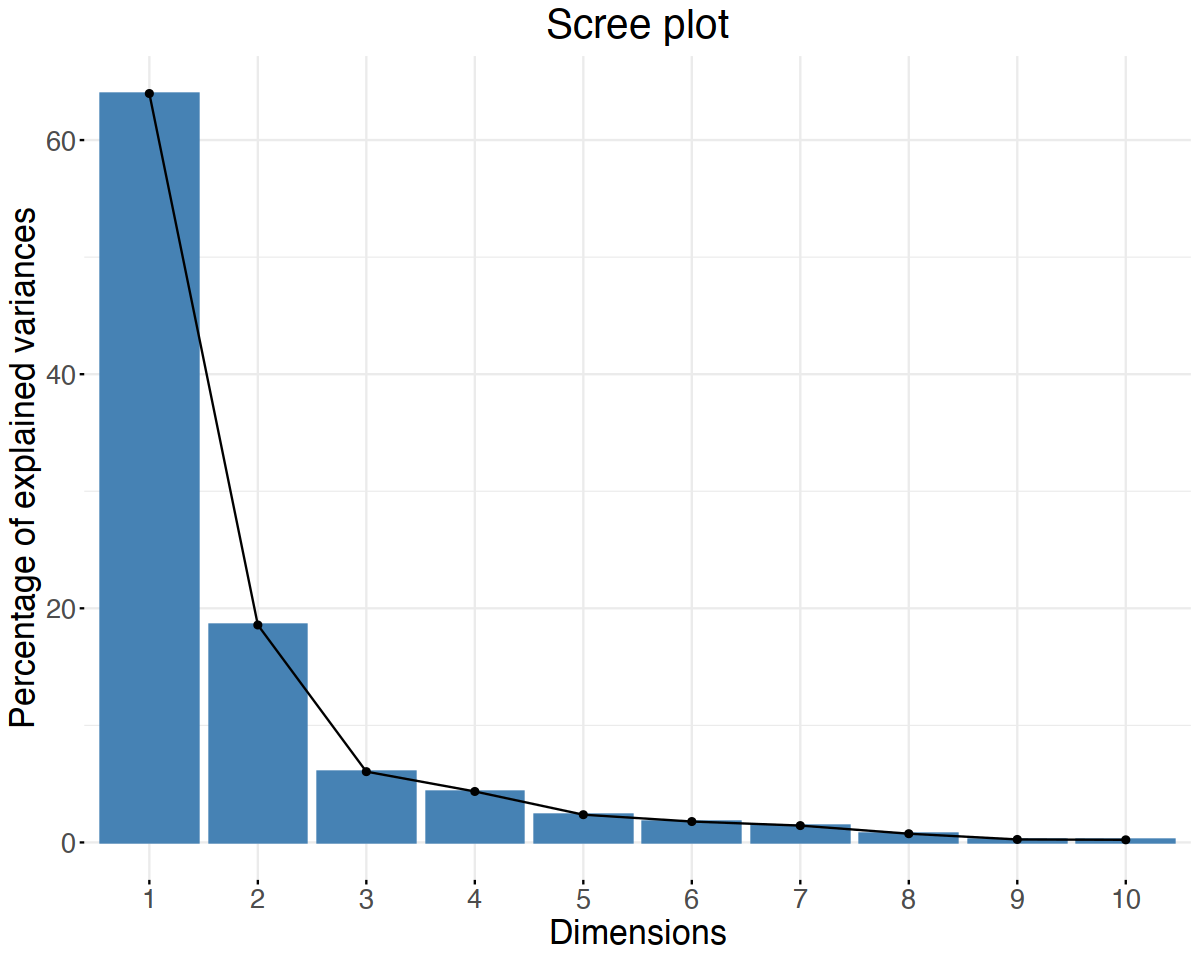

In [8]:
# Plot screeplot to help select how many PCAs to keep
options(repr.plot.width=10, repr.plot.height=8)
fviz_eig(pca) + theme(
    plot.title = element_text(hjust = 0.5),
    text = element_text(size = 20)
) 

This suggests that first 2 PCA components should probably be kept. Third one has an extra 6% of explained variance. Some additional analysis can be done to verify if clustering has more informative results with 3 PCAs instead of 2. 

### Plot first two PCAs and existing features

Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


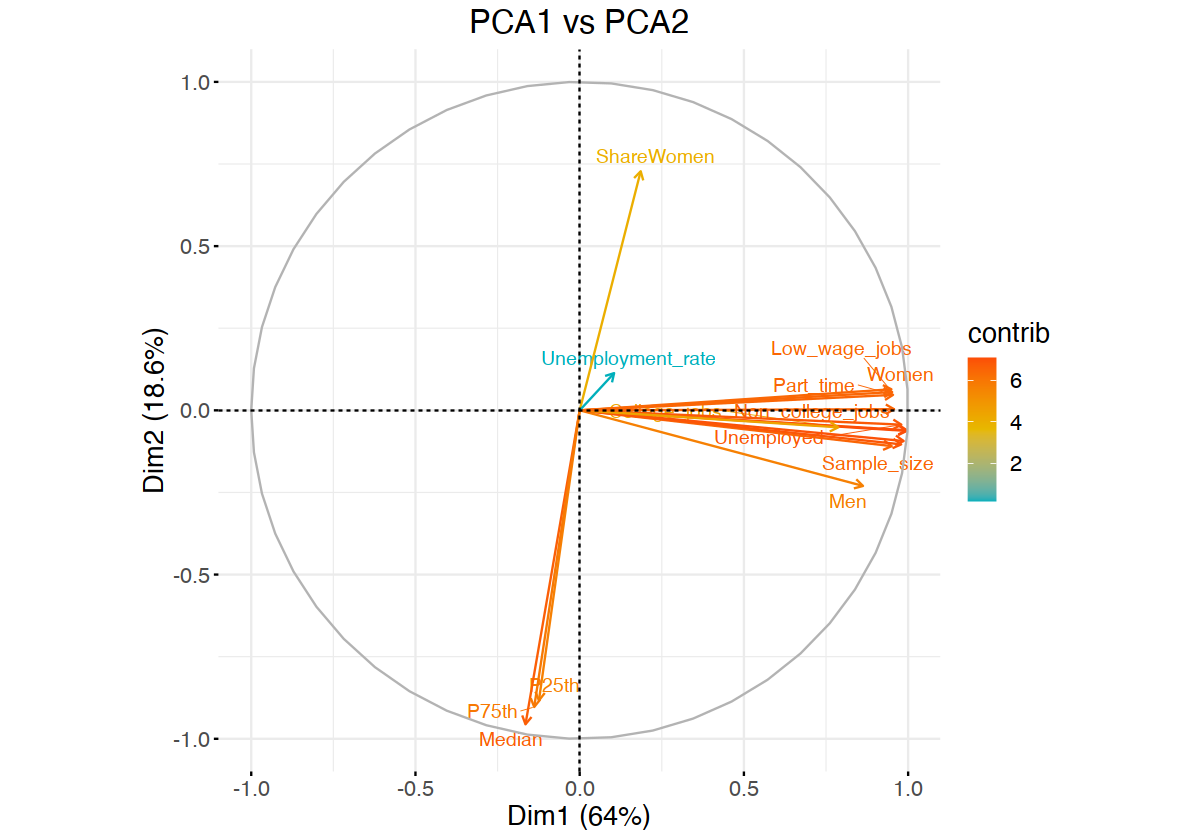

In [9]:
options(repr.plot.width=10, repr.plot.height=7)
factoextra::fviz_pca_var(pca,              
             col.var = "contrib", # Color by contributions to the PC
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE,
             title = "PCA1 vs PCA2") + theme(
    plot.title = element_text(hjust = 0.5),
    text = element_text(size = 16)
)

In [10]:
# Function to compute the Gini Index of a cluster
get_gini = function(clusters) {
    grouped = clusters %>% group_by(category) %>% count()
    grouped["percentage"] = grouped["n"] / sum(grouped["n"])
    
    return(sum(grouped["percentage"]  * (1 - grouped["percentage"])))
}

In [11]:
# This is my St Andrews ID, use it for reproductibility
set.seed(210001411)

# Store best configuration for the clusters
best_gini = 1
best_configuration = -1
best_km = NA
ginies_per_cluster = c()
best_clusters = NA

# For each number of clusters selected
# Calculate the gini index of each cluster 
# and find the mean gini index for a particular
# number of clusters between all clusters

for(nr_clusters in seq(2, 16)) {
    res.km = kmeans(pca$x[1:172, 1:2], nr_clusters, nstart=20, iter.max=500)
    clusters = data.frame(cluster=res.km$cluster, major=data$Major, category = data$Major_category)
    clusters = clusters[order(clusters$category), ]
    
    ginies = c()
    total_gini = 0
    
    for(i in seq(1:nr_clusters)) {
        # Calculate gini index for each cluster
        cluster_gini = get_gini(clusters[clusters["cluster"] == i, ])
        ginies = c(ginies, cluster_gini)
        total_gini = total_gini + cluster_gini
    }
        
    mean_gini = total_gini/nr_clusters
    if(mean_gini < best_gini - 0.05) {
        # If this gini is significantly improving the 
        # best configuration so far, store it.
        # If the improvement is not large enough, 
        # avoid storing a very high number of clusters
        
        best_gini = mean_gini
        best_configuration = nr_clusters
        best_km = res.km
        ginies_per_cluster = ginies
        best_clusters = clusters
    }
}
print(paste("Best gini index", round(best_gini, 2), "and number of clusters", best_configuration))
gini_by_cluster = data.frame(cluster = seq(1, best_configuration), gini = ginies_per_cluster)
gini_by_cluster = gini_by_cluster[order(gini_by_cluster$gini),]

[1] "Best gini index 0.64 and number of clusters 9"


In [13]:
# Attach a column for the cluster index in the initial dataset
names(best_clusters)[names(best_clusters) == 'major'] = 'Major'
data = merge(x=data,y=best_clusters[-c(3)],by="Major")

In [ ]:
# Find summaries for each cluster (in this case the mean)
data %>% select(-Major, -Major_category) %>% group_by(data$cluster) %>% summarise(across(everything(), mean))

### Visualise polygons of clusters in 2D using the first two PCAs
Alternatively the data can be the initial datapoints and pairs of features from it.

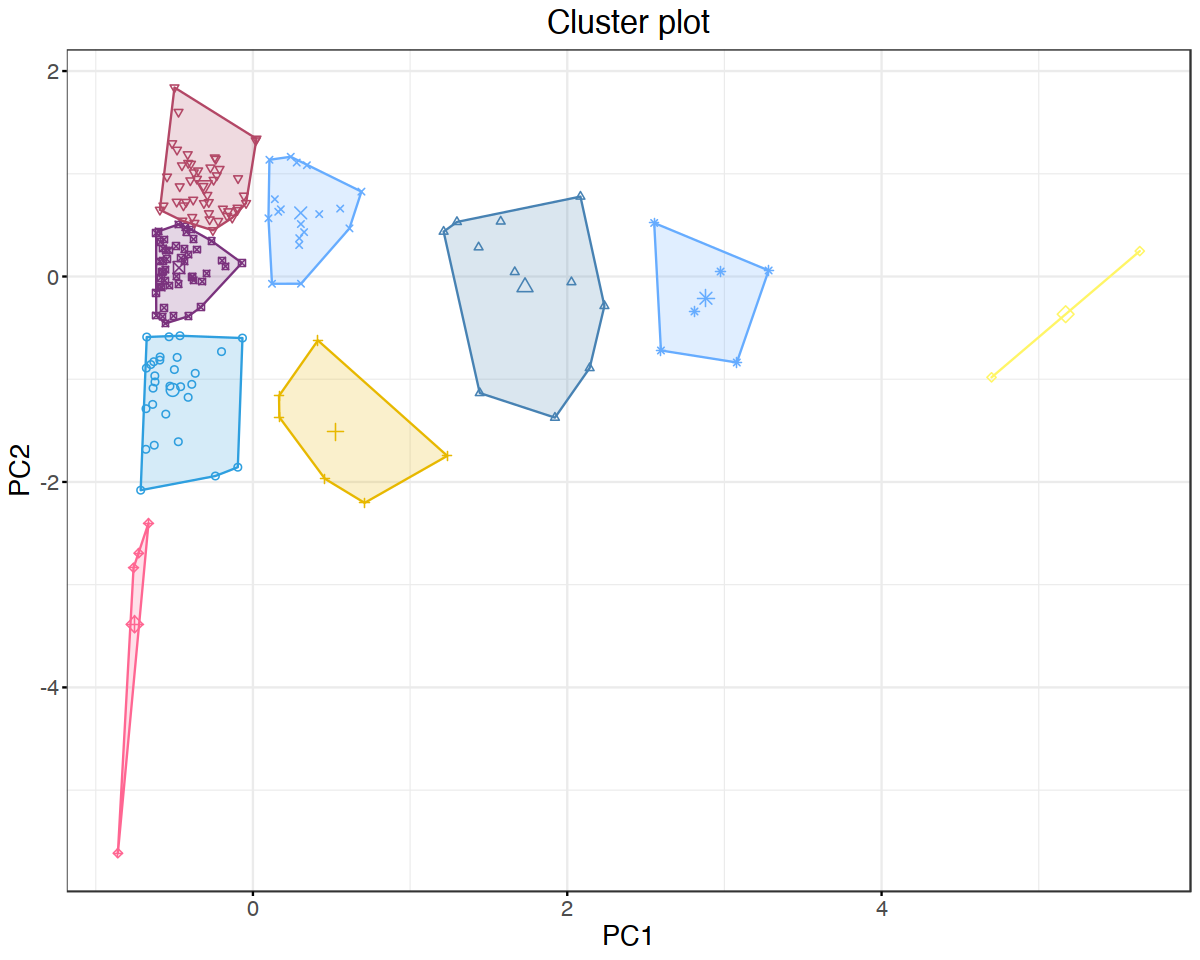

In [15]:
options(repr.plot.width=10, repr.plot.height=8)
fviz_cluster(best_km, data = pca$x[1:172, 1:2],
             palette = palette, 
             geom = "point",
             ellipse.type = "convex", 
             ggtheme = theme_bw()
             ) + theme(
    plot.title = element_text(hjust = 0.5),
    text = element_text(size = 16),
    legend.position="none"
)

### Find if number of clusters can be picked using sillhouette plots

  cluster size ave.sil.width
1       1   29          0.43
2       2   11          0.30
3       3    6          0.27
4       4   18          0.49
5       5    2          0.49
6       6   48          0.39
7       7   48          0.46
8       8    6          0.55
9       9    4          0.27


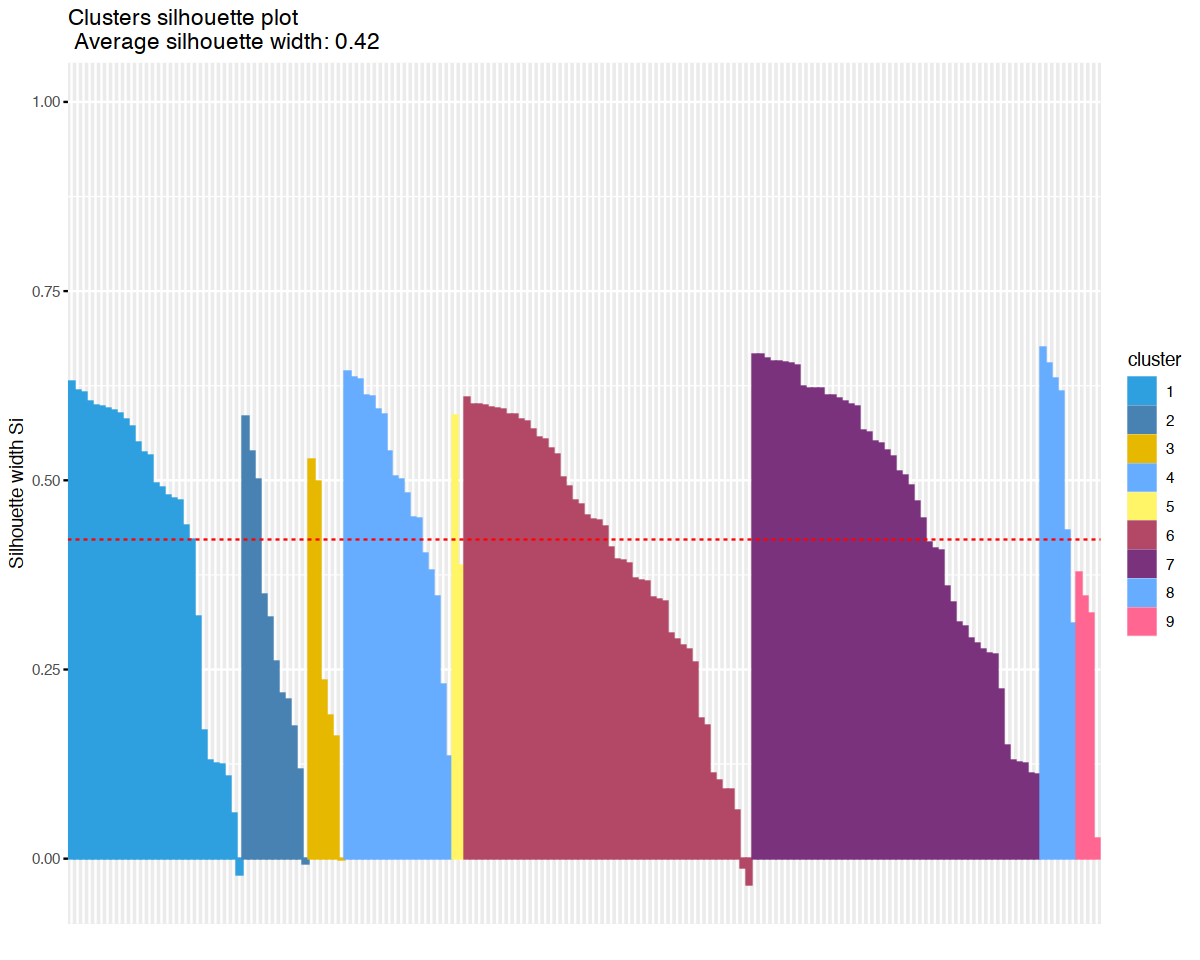

In [16]:
sil <- silhouette(x = best_km$cluster, dist = dist(pca$x[1:172, 1:2]))
fviz_silhouette(sil) +
scale_fill_manual(values = palette) +
scale_color_manual(values = palette)

### Does gap metric suggest a better number of clusters ?

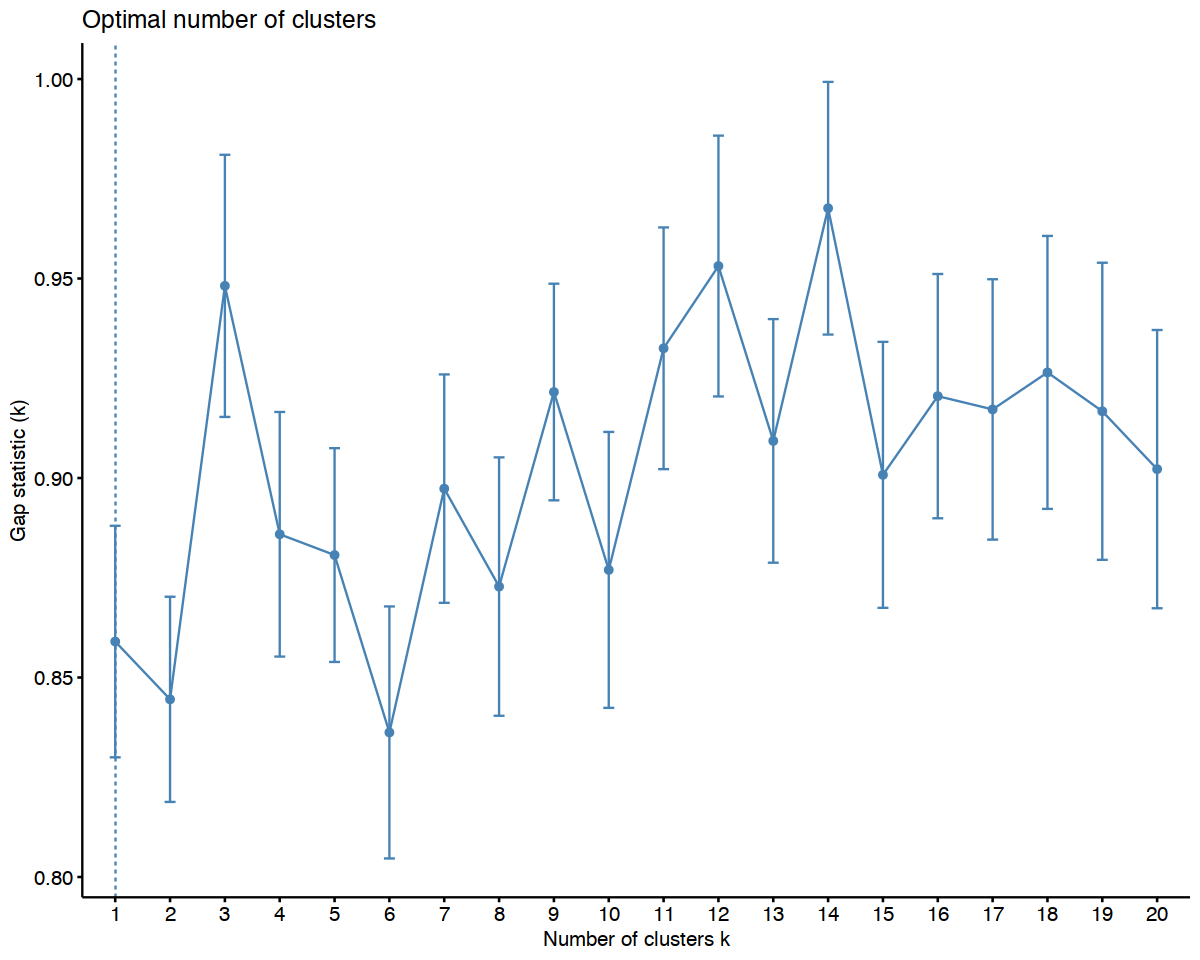

In [18]:
fviz_nbclust(x = pca$x[1:172, 1:2], FUNcluster = kmeans, method = "gap", k.max = 20)